In [61]:
import pandas as pd
import numpy as np

In [62]:
## Загрузка датасета
df_crops = pd.read_parquet('../data/classification/raw_eegs_crops.parquet')

## настройка таргета
df_crops['target'] = df_crops['segment_type'].apply(lambda x: 1 if x == 'S1' else 0)

## Разделяем на train/val по subject_id
unique_subjects = df_crops["subject_id"].unique()
np.random.seed(42)
np.random.shuffle(unique_subjects)
train_subjects = unique_subjects[:23]
val_subjects = unique_subjects[23:]

In [63]:
# сплит датасета
train_mask = df_crops["subject_id"].isin(train_subjects)
val_mask = df_crops["subject_id"].isin(val_subjects)
df_train = df_crops[train_mask].reset_index(drop=True)
df_val = df_crops[val_mask].reset_index(drop=True)

print(f"Train crops: {len(df_train)}; Val crops: {len(df_val)}")

Train crops: 5814; Val crops: 1027


In [64]:
X_train = df_train['crop_path'].values
y_train = df_train['target'].values
X_val = df_val['crop_path'].values
y_val = df_val['target'].values

In [53]:
# тестовый сплит с рандомом по всем строкам 80/20
np.random.seed(42)
df_crops = df_crops.sample(frac=1).reset_index(drop=True)
train_crops = df_crops[:int(len(df_crops) * 0.8)]
val_crops = df_crops[int(len(df_crops) * 0.8):]

In [54]:
X_train = train_crops['crop_path'].values
y_train = train_crops['target'].values
X_val = val_crops['crop_path'].values
y_val = val_crops['target'].values

In [65]:
## Модель

# Define model: conv - batch_norm - silu x4, global average pooling, no dropout
import torch

class EEGNet(torch.nn.Module):
    def __init__(self, n_channels=128, in_samples=2500, n_classes=2):
        super(EEGNet, self).__init__()
        self.conv1 = torch.nn.Conv1d(n_channels, 64, kernel_size=7, stride=1, padding=3)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.conv2 = torch.nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.conv3 = torch.nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.conv4 = torch.nn.Conv1d(256, 512, kernel_size=1, stride=1)
        self.bn4 = torch.nn.BatchNorm1d(512)
        # Global average pooling (output: batch x 512 x 1)
        self.global_pool = torch.nn.AdaptiveAvgPool1d(1)
        self.fc = torch.nn.Linear(512, n_classes)

    def forward(self, x):
        x = torch.nn.functional.silu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.silu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.silu(self.bn3(self.conv3(x)))
        x = torch.nn.functional.silu(self.bn4(self.conv4(x)))
        x = self.global_pool(x)        # shape: (batch, 512, 1)
        x = x.squeeze(-1)              # shape: (batch, 512)
        x = self.fc(x)                 # shape: (batch, n_classes)
        return x

In [66]:
# load model and test input batch
model = EEGNet(n_channels=128, in_samples=2500, n_classes=2)
inputs = torch.randn(128, 128, 2500)
outputs = model(inputs)
print(outputs.shape)


torch.Size([128, 2])


## Обучение модели

Train class distribution: {np.int64(0): np.int64(2543), np.int64(1): np.int64(3271)}
Val class distribution: {np.int64(0): np.int64(488), np.int64(1): np.int64(539)}


Epoch 1/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/25: train_loss=0.0000, train_acc=0.7907, val_loss=0.0001, val_acc=0.5803


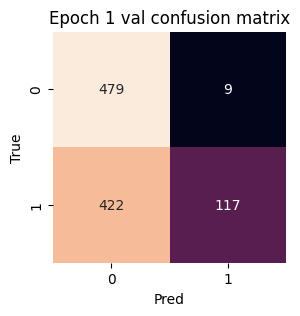

Model saved (best val_loss).


Epoch 2/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/25: train_loss=0.0000, train_acc=0.8787, val_loss=0.0002, val_acc=0.5239


Epoch 3/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/25: train_loss=0.0000, train_acc=0.8930, val_loss=0.0001, val_acc=0.6563


Epoch 4/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/25: train_loss=0.0000, train_acc=0.9145, val_loss=0.0002, val_acc=0.6173


Epoch 5/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/25: train_loss=0.0000, train_acc=0.9235, val_loss=0.0002, val_acc=0.6008


Epoch 6/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/25: train_loss=0.0000, train_acc=0.9305, val_loss=0.0002, val_acc=0.6008


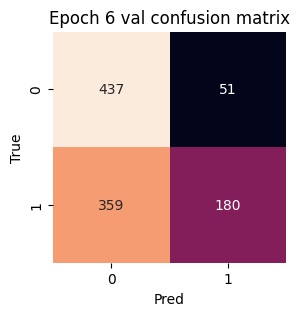

Epoch 7/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/25: train_loss=0.0000, train_acc=0.9443, val_loss=0.0003, val_acc=0.5784


Epoch 8/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/25: train_loss=0.0000, train_acc=0.9513, val_loss=0.0003, val_acc=0.5667


Epoch 9/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/25: train_loss=0.0000, train_acc=0.9544, val_loss=0.0003, val_acc=0.5628


Epoch 10/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/25: train_loss=0.0000, train_acc=0.9611, val_loss=0.0004, val_acc=0.5463


Epoch 11/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/25: train_loss=0.0000, train_acc=0.9639, val_loss=0.0003, val_acc=0.5949


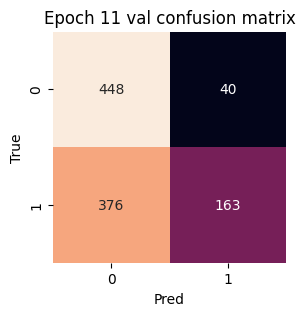

Epoch 12/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>can only test a child process

Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/

Epoch 12/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0><function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
  F

Epoch 12/25: train_loss=0.0000, train_acc=0.9709, val_loss=0.0003, val_acc=0.5794


Epoch 13/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/

Epoch 13/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/

Epoch 13/25: train_loss=0.0000, train_acc=0.9733, val_loss=0.0003, val_acc=0.5803


Epoch 14/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/

Epoch 14/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>

Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiPro

Epoch 14/25: train_loss=0.0000, train_acc=0.9745, val_loss=0.0003, val_acc=0.5657


Epoch 15/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72cafe7b6ac0>
Traceback (most recent call last):
  File "/home/whatislove/miniconda3/envs/phd/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/whatislove/miniconda3/envs/

Epoch 15/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/25: train_loss=0.0000, train_acc=0.9761, val_loss=0.0003, val_acc=0.5706


Epoch 16/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/25: train_loss=0.0000, train_acc=0.9761, val_loss=0.0004, val_acc=0.5745


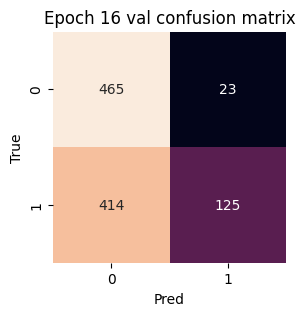

Epoch 17/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 17/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/25: train_loss=0.0000, train_acc=0.9830, val_loss=0.0003, val_acc=0.5648


Epoch 18/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/25: train_loss=0.0000, train_acc=0.9852, val_loss=0.0004, val_acc=0.5686


Epoch 19/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 19/25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/25: train_loss=0.0000, train_acc=0.9845, val_loss=0.0004, val_acc=0.5667


Epoch 20/25 [train]:   0%|          | 0/46 [00:00<?, ?it/s]

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# =====================================
# 1. Более корректный препроцессинг EEG
# =====================================
from scipy import signal

def preprocess_eeg(eeg: np.ndarray, fs: int = 250):
    # eeg: shape (128, 2500)
    sos = signal.butter(4, [0.5, 45], btype='bandpass', fs=fs, output='sos')
    eeg_bp = signal.sosfiltfilt(sos, eeg)
    mean = np.median(eeg_bp, axis=1, keepdims=True)
    std = np.subtract(*np.percentile(eeg_bp, [75, 25], axis=1, keepdims=True)) / 1.349  # robust std
    eeg_norm = (eeg_bp - mean) / (std + 1e-6)
    return eeg_norm.astype(np.float32)

class EEGDataset(Dataset):
    def __init__(self, X_paths, y, fs=250, preprocess=True):
        self.X_paths = np.array(X_paths)
        self.y = np.array(y, dtype=np.int64)
        self.fs = fs
        self.preprocess = preprocess
    def __len__(self):
        return len(self.X_paths)
    def __getitem__(self, idx):
        x = np.load(self.X_paths[idx]).astype(np.float32)
        if self.preprocess:
            x = preprocess_eeg(x, fs=self.fs)
        return torch.from_numpy(x), torch.tensor(self.y[idx], dtype=torch.float32)  # float32 for BCE loss

# X_train, y_train, X_val, y_val — массивы путей и меток
train_dataset = EEGDataset(X_train, y_train, preprocess=True)
val_dataset = EEGDataset(X_val, y_val, preprocess=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

# ===================================
# 2. Проверка баланса классов - print
# ===================================
values, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(values, counts)))
values, counts = np.unique(y_val, return_counts=True)
print("Val class distribution:", dict(zip(values, counts)))

# ===================================
# 3. Фокал лосс и сигмоидная активация (важно!)
# ===================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Переделать модель: выход только 1 нейрон (бин. классификация)
class EEGNetSigmoid(torch.nn.Module):
    def __init__(self, n_channels=128, in_samples=2500):
        super(EEGNetSigmoid, self).__init__()
        self.conv1 = torch.nn.Conv1d(n_channels, 64, kernel_size=7, stride=1, padding=3)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.conv2 = torch.nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.conv3 = torch.nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.conv4 = torch.nn.Conv1d(256, 512, kernel_size=1, stride=1)
        self.bn4 = torch.nn.BatchNorm1d(512)
        self.global_pool = torch.nn.AdaptiveAvgPool1d(1)
        self.fc = torch.nn.Linear(512, 1)  # Один выход
    def forward(self, x):
        x = torch.nn.functional.silu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.silu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.silu(self.bn3(self.conv3(x)))
        x = torch.nn.functional.silu(self.bn4(self.conv4(x)))
        x = self.global_pool(x)        # shape: (batch, 512, 1)
        x = x.squeeze(-1)              # shape: (batch, 512)
        x = self.fc(x)                 # shape: (batch, 1)
        x = torch.sigmoid(x)           # сигмоида на выходе
        return x.squeeze(-1)           # shape: (batch,)

model = EEGNetSigmoid(n_channels=128, in_samples=2500).to(device)

# считаем веса классов для фокал лосса (можно по аналогии, как для BCE)
class_sample_count = np.array([(y_train == t).sum() for t in np.unique(y_train)])
weight = 1. / class_sample_count
class_weights = torch.tensor(weight, dtype=torch.float32, device=device)

# --- Фокал лосс с поддержкой весов классов ---
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # тензор длины 2 (по классам) или None
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        # inputs: batch, (float in [0, 1]), targets: batch, (float in {0, 1})
        eps = 1e-6
        # BCE
        bce_loss = - (targets * torch.log(inputs.clamp(min=eps,max=1-eps)) + 
                      (1 - targets) * torch.log(1 - inputs.clamp(min=eps,max=1-eps)))
        pt = inputs * targets + (1 - inputs) * (1 - targets)
        focal_weight = (1 - pt) ** self.gamma
        if self.alpha is not None:
            at = self.alpha[1] * targets + self.alpha[0] * (1 - targets)  # выделяем веса для 0 и 1 класса
            focal_weight = focal_weight * at
        loss = focal_weight * bce_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

# alpha заполняется из весов классов
alpha = class_weights
criterion = FocalLoss(alpha=alpha, gamma=2.0, reduction='mean')  # gamma можно менять

# ====================================
# 4. Меньше lr, clip градиенты
# ====================================
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# ============================
# 5. Используем lr_scheduler
# ============================
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

n_epochs = 25
best_val_loss = float('inf')
max_grad_norm = 2.0

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [train]", leave=False)
    for xb, yb in progress:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)  # shape: (batch,)
        loss = criterion(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        preds = (out > 0.5).long()
        train_correct += (preds == yb.long()).sum().item()
        train_total += xb.size(0)
        progress.set_postfix(loss=loss.item(),
                             acc=(preds == yb.long()).float().mean().item(),
                             lr=optimizer.param_groups[0]['lr'])
    train_loss /= train_total
    train_acc = train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    progress_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [val]", leave=False)
    with torch.no_grad():
        for xb, yb in progress_val:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item() * xb.size(0)
            preds = (out > 0.5).long()
            val_correct += (preds == yb.long()).sum().item()
            val_total += xb.size(0)
            progress_val.set_postfix(loss=loss.item(),
                                     acc=(preds == yb.long()).float().mean().item())
    val_loss /= val_total
    val_acc = val_correct / val_total

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    # ------------------
    # 6. Show confusion matrix for validation for debug!
    # ------------------
    if epoch % 5 == 0 or epoch == n_epochs-1:
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        all_val_preds = []
        all_val_true = []
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            with torch.no_grad():
                logits = model(xb)
                preds = (logits > 0.5).long().cpu().numpy()
            all_val_preds.extend(preds)
            all_val_true.extend(yb.cpu().numpy())
        cm = confusion_matrix(all_val_true, all_val_preds)
        plt.figure(figsize=(3,3))
        sns.heatmap(cm, annot=True, fmt='d', cbar=False)
        plt.title(f"Epoch {epoch+1} val confusion matrix")
        plt.xlabel("Pred")
        plt.ylabel("True")
        plt.show()

    # Сохраняем лучшую модель
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_eegnet.pth")
        print("Model saved (best val_loss).")

fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(history["train_loss"], label="Train loss")
axs[0].plot(history["val_loss"], label="Val loss")
axs[0].set_title("Loss")
axs[0].legend()
axs[1].plot(history["train_acc"], label="Train acc")
axs[1].plot(history["val_acc"], label="Val acc")
axs[1].set_title("Accuracy")
axs[1].legend()
plt.show()

In [68]:
## получение предсказаний на валид датасете df_val
# Получение предсказаний на валид датасете с мёржом с df_val и прогресс-баром
model.eval()
all_preds = []
all_true = []

from tqdm.notebook import tqdm

with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Predicting val set"):
        xb = xb.to(device)
        out = model(xb)
        preds = out.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

# Добавляем предсказания и истинные значения в df_val
df_val = df_val.copy()
df_val["y_true"] = all_true
df_val["y_pred"] = all_preds

display(df_val.head())

Predicting val set:   0%|          | 0/9 [00:00<?, ?it/s]

,crop_path,subject_id,session_type,mono,segment_type,segment_orig_start,segment_orig_end,crop_start_time,crop_end_time,good_eeg,target,y_true,y_pred
0,../data/classification_crops/Co_y6_016st_fon1_...,Co_y6_016st,fon,False,S1,7.869,127.416,12.869,17.869,True,1,1,1
1,../data/classification_crops/Co_y6_016st_fon1_...,Co_y6_016st,fon,False,S1,7.869,127.416,15.869,20.869,True,1,1,1
2,../data/classification_crops/Co_y6_016st_fon1_...,Co_y6_016st,fon,False,S1,7.869,127.416,18.869,23.869,True,1,1,1
3,../data/classification_crops/Co_y6_016st_fon1_...,Co_y6_016st,fon,False,S1,7.869,127.416,21.869,26.869,True,1,1,1
4,../data/classification_crops/Co_y6_016st_fon1_...,Co_y6_016st,fon,False,S1,7.869,127.416,24.869,29.869,True,1,1,1


In [69]:
df_val.y_pred.value_counts()

y_pred
0    816
1    211
Name: count, dtype: int64

In [70]:
df_val.target.value_counts()

target
1    539
0    488
Name: count, dtype: int64

In [5]:
train_subjects

array(['Mor_y1_003', 'Co_y6_040', 'Co_y6_026', 'Co_y6_072', 'Co_y6_021',
       'Co_y6_022', 'Co_y6_069', 'Co_y6_003', 'Mor_y1_002', 'Co_y6_027',
       'Co_y6_035', 'Co_y6_025', 'Co_y6_041', 'Co_y6_008', 'Co_y6_013',
       'Co_y6_014', 'Co_y6_009', 'Co_y6_084', 'Co_y6_010', 'Co_y6_073',
       'Mor_y1_001', 'Co_y6_043', 'Mor_y1_004'], dtype=object)